## Notebook to construct a graph based upon similarity between tunes:

Similarity is measured by least average Euclidean distance.

Community detection is then run on the graph, in order to find whether clusters correspond to time periods.

In [1]:
import math
import pickle
import numpy as np

### Load data and pre-process:

In [2]:
with open('./Dataset/file_features_clean.pkl', 'rb') as f:
    # Load the serialized object from the file
    file_features = pickle.load(f)

with open('./Dataset/normalised_pitch_vectors_clean.pkl', 'rb') as f:
    # Load the serialized object from the file
    normalised_pitch_vectors = pickle.load(f)

with open('./Dataset/normalised_rhythm_vectors_clean.pkl', 'rb') as f:
    # Load the serialized object from the file
    normalised_rhythm_vectors = pickle.load(f)

with open('./Dataset/10_class_tune_year_labels.pkl', 'rb') as f: # Change as needed
    tune_year_labels = pickle.load(f)

num_classes = 10

In [68]:
tune_year_labels

,tune,year,true_year
0,1795_Gretna Green. VWMLa.193.abc,1775,1795
1,1827_Bath Waltz. JC.168.abc,1825,1827
2,1860_Saxon Waltz. TLY.030.abc,1850,1860
3,1756_Better Day Better Deed. WCD3.abc,1750,1756
4,1833_Green Hills of Tyrol. LW.099.abc,1825,1833
...,...,...,...
995,1651_Kemp's Jig.abc,1650,1651
996,1651_Rose is White and Rose is Red.abc,1650,1651
997,1651_Millfield.abc,1650,1651
998,1651_Paul's Wharf.abc,1650,1651


In [69]:
# Delete any tunes with empty pitch and/or rhythm vectors:
print('...Cleaning node feature data by deleting tunes with empty features')
deleted_tunes = []
for tune, vectors in file_features.items():
    pitch_vector = vectors[0]
    rhythm_vector = vectors[1]

    if (len(pitch_vector) == 0) or (len(rhythm_vector) == 0):
        deleted_tunes.append((tune, vectors))

print('number of tunes to delete:', len(deleted_tunes))
for tune in deleted_tunes:
    del file_features[tune[0]]
deleted_tune_names = [tune[0] for tune in deleted_tunes]
print('...Finished cleaning node data')


# Only look at tunes that are in the balanced data:
relevant_tunes = list(tune_year_labels['tune'])
file_features = {key: value for key, value in file_features.items() if key in relevant_tunes}
normalised_pitch_vectors = {key: value for key, value in normalised_pitch_vectors.items() if key in relevant_tunes}
normalised_rhythm_vectors = {key: value for key, value in normalised_rhythm_vectors.items() if key in relevant_tunes}


...Cleaning node feature data by deleting tunes with empty features
number of tunes to delete: 0
...Finished cleaning node data


### Calculate Euclidean distance:

#### Calculate on combined normalised vectors:

In [70]:
rhythm_features_lst = list(normalised_rhythm_vectors.items())
pitch_features_lst = list(normalised_pitch_vectors.items())
tune_similarity_dict = {}

# Iterate through each tune and calculate it's distance from every other tune (in terms of pitch vector)
count = 0
for i in range(len(rhythm_features_lst)-1):
    similarity_lst = []
    tune_i_name = rhythm_features_lst[i][0]
    tune_i_rhythm = rhythm_features_lst[i][1]
    tune_i_pitch = pitch_features_lst[i][1]
    
    for j in range(len(rhythm_features_lst)-1):
        if i != j:
            tune_j_name = rhythm_features_lst[j][0]
            tune_j_rhythm = rhythm_features_lst[j][1]
            tune_j_pitch = pitch_features_lst[j][1]


            ## Calculate the difference between pitch vectors:
            min_rhythm_similarity = math.dist(tune_i_rhythm, tune_j_rhythm)
            min_pitch_similarity = math.dist(tune_i_pitch, tune_j_pitch)


            # Store in list:
            similarity_lst.append((tune_j_name, min_pitch_similarity, min_rhythm_similarity))
    
    # Store 100 most similar in tune_similarity_dict:
    similarity_lst.sort(key=lambda x: np.mean((x[1],x[2])))
    if similarity_lst and len(similarity_lst) > 100:
        similarity_lst = similarity_lst[:100]
    tune_similarity_dict[tune_i_name] = similarity_lst
    count += 1
    
    if count % 25 == 0:
        print(f'Processed: {count} tunes')


Processed: 25 tunes
Processed: 50 tunes
Processed: 75 tunes
Processed: 100 tunes
Processed: 125 tunes
Processed: 150 tunes
Processed: 175 tunes
Processed: 200 tunes
Processed: 225 tunes
Processed: 250 tunes
Processed: 275 tunes
Processed: 300 tunes
Processed: 325 tunes
Processed: 350 tunes
Processed: 375 tunes
Processed: 400 tunes
Processed: 425 tunes
Processed: 450 tunes
Processed: 475 tunes
Processed: 500 tunes
Processed: 525 tunes
Processed: 550 tunes
Processed: 575 tunes
Processed: 600 tunes
Processed: 625 tunes
Processed: 650 tunes
Processed: 675 tunes
Processed: 700 tunes
Processed: 725 tunes
Processed: 750 tunes
Processed: 775 tunes
Processed: 800 tunes
Processed: 825 tunes
Processed: 850 tunes
Processed: 875 tunes
Processed: 900 tunes
Processed: 925 tunes
Processed: 950 tunes
Processed: 975 tunes


In [71]:
# Calculate accuracy:
'''
This measures how many tunes are within 50 years of the date of the tune
'''

accuracies = []
correct_1650 = 0
correct_1675 = 0
correct_1700 = 0
correct_1725 = 0
correct_1750 = 0
correct_1775 = 0
correct_1800 = 0
correct_1825 = 0
correct_1850 = 0
correct_1875 = 0

num_1650 = 0
num_1675 = 0
num_1700 = 0
num_1725 = 0
num_1750 = 0
num_1775 = 0
num_1800 = 0
num_1825 = 0
num_1850 = 0
num_1875 = 0

for tune, similar_tunes in tune_similarity_dict.items():
    tune_year = int(tune[:4])

    correct = 0
    if similar_tunes:
        num_tunes = len(similar_tunes)
        for similar_tune in similar_tunes:
            similar_tune_year = int(similar_tune[0][:4])


            if num_classes == 5:
                # Round both tune years to the nearest 50 year period and compare:
                remainder = tune_year % 50
                if remainder < 25:
                    tune_year = tune_year - remainder
                else:
                    tune_year = tune_year + (50 - remainder)
                
                remainder = similar_tune_year % 50
                if remainder < 25:
                    similar_tune_year = similar_tune_year - remainder
                else:
                    similar_tune_year = similar_tune_year + (50 - remainder)
                
                # Count number of each class:
                if tune_year == 1650:
                    num_1650 += 1
                if tune_year == 1700:
                    num_1700 += 1
                if tune_year == 1750:
                    num_1750 += 1
                if tune_year == 1800:
                    num_1800 += 1
                if tune_year == 1850:
                    num_1850 += 1

                if tune_year == similar_tune_year:
                    correct += 1

                    if tune_year == 1650:
                        correct_1650 += 1
                    if tune_year == 1700:
                        correct_1700 += 1
                    if tune_year == 1750:
                        correct_1750 += 1
                    if tune_year == 1800:
                        correct_1800 += 1
                    if tune_year == 1850:
                        correct_1850 += 1

            # Round both tune years to the nearest 25 year period and compare:

            if num_classes == 10:
                remainder = tune_year % 25
                if remainder < 12.5:
                    tune_year = tune_year - remainder
                else:
                    tune_year = tune_year + (25 - remainder)

                remainder = similar_tune_year % 25
                if remainder < 12.5:
                    similar_tune_year = similar_tune_year - remainder
                else:
                    similar_tune_year = similar_tune_year + (25 - remainder)
                
                if tune_year == 1650:
                    num_1650 += 1
                if tune_year == 1675:
                    num_1675 += 1
                if tune_year == 1700:
                    num_1700 += 1
                if tune_year == 1725:
                    num_1725 += 1
                if tune_year == 1750:
                    num_1750 += 1
                if tune_year == 1775:
                    num_1775 += 1
                if tune_year == 1800:
                    num_1800 += 1
                if tune_year == 1825:
                    num_1825 += 1
                if tune_year == 1850:
                    num_1850 += 1
                if tune_year == 1875:
                    num_1875 += 1

                if tune_year == similar_tune_year:
                    correct += 1

                    if tune_year == 1650:
                        correct_1650 += 1
                    if tune_year == 1675:
                        correct_1675 += 1
                    if tune_year == 1700:
                        correct_1700 += 1
                    if tune_year == 1725:
                        correct_1725 += 1
                    if tune_year == 1750:
                        correct_1750 += 1
                    if tune_year == 1775:
                        correct_1775 += 1
                    if tune_year == 1800:
                        correct_1800 += 1
                    if tune_year == 1825:
                        correct_1825 += 1
                    if tune_year == 1850:
                        correct_1850 += 1
                    if tune_year == 1875:
                        correct_1875 += 1

    accuracy = correct / num_tunes
    accuracies.append(accuracy)

# Calculate percentage correct for each class:
try:
    correct_1650 = correct_1650 / num_1650
except:
    pass
try:
    correct_1675 = correct_1675 / num_1675
except:
    pass
try:
    correct_1700 = correct_1700 / num_1700
except:
    pass
try:
    correct_1725 = correct_1725 / num_1725
except:
    pass
try:
    correct_1750 = correct_1750 / num_1750
except:
    pass
try:
    correct_1775 = correct_1775 / num_1775
except:
    pass
try:
    correct_1800 = correct_1800 / num_1800
except:
    pass
try:
    correct_1825 = correct_1825 / num_1825
except:
    pass
try:
    correct_1850 = correct_1850 / num_1850
except:
    pass
try:
    correct_1875 = correct_1875 / num_1875
except:
    pass

print('average accuracy:', np.mean(accuracies))
print('Correct 1650: ', correct_1650)
print('Correct 1675: ', correct_1675)
print('Correct 1700: ', correct_1700)
print('Correct 1725: ', correct_1725)
print('Correct 1750: ', correct_1750)
print('Correct 1775: ', correct_1775)
print('Correct 1800: ', correct_1800)
print('Correct 1825: ', correct_1825)
print('Correct 1850: ', correct_1850)
print('Correct 1875: ', correct_1825)




average accuracy: 0.1876076076076076
Correct 1650:  0.4265656565656566
Correct 1675:  0
Correct 1700:  0.18787037037037038
Correct 1725:  0.17675925925925925
Correct 1750:  0.21025
Correct 1775:  0.11507692307692308
Correct 1800:  0.16610169491525423
Correct 1825:  0.16056910569105692
Correct 1850:  0.15949152542372882
Correct 1875:  0.16056910569105692


### Create NetworkX Graph:

In [72]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import davies_bouldin_score
from scipy import stats
from scipy.spatial import ConvexHull

#### Create edge-list:

In [73]:
edge_lst = []
for tune, neighbours in tune_similarity_dict.items():
    for neighbour in neighbours:
        neighbour_name = neighbour[0]
        edge_cost = 0.5 * (neighbour[1] + neighbour[2])
        edge_lst.append((tune, neighbour_name, edge_cost))

#### Create NetworkX Graph:

In [74]:
# Create a graph:
G = nx.Graph()

# Add weighted edges to the graph:
G.add_weighted_edges_from(edge_lst)
G.nodes

NodeView(('1795_Gretna Green. VWMLa.193.abc', '1750_Ward’s Fancy. JJo5.086.abc', '1783_the Highland Spell.abc', '1718_Prelude by Dean(06). TBe.006.abc', "1810_42nd Reg't Welcome Home Again. RH.361, The.abc", '1748_Trip to Lairey. JJo4.138.abc', '1694_Untitled. HA.062.abc', '1750_Fort William. JJo5.082.abc', '1875_Yankee Doodle WES.057.abc', '1795_La Fete da Bruge. VWMLa.156.abc', '1779_Se(ampton?)Cade. JBi.18.abc', '1825_Bonaparty in a Knapsack. JBut.778.abc', "1889_Jan's courtship - rowe.abc", '1779_Ladies Breast Knot. JBi.17, The.abc', '1816_Theres Nae Luck About the House. TWC.055.abc', '1875_Yellow Rose of Texas.  WES.018, The.abc', "1823_Devil's Dead. HSJJ.123, The.abc", '1810_Russian Dance. RH.086, The.abc', '1740_the Surly.abc', '1779_Greenwich Park.abc', "1801_Duke's Whim. JJo.114, The.abc", '1875_Billy Pitt. HS.18.abc', '1798_Rose.  TJD.15, The.abc', '1745_Alister.abc', "1758_Jack's Delight THO1.190.abc", '1779_Swab the Decks. JBi.55.abc', '1875_So Early in the Morning  WES.02

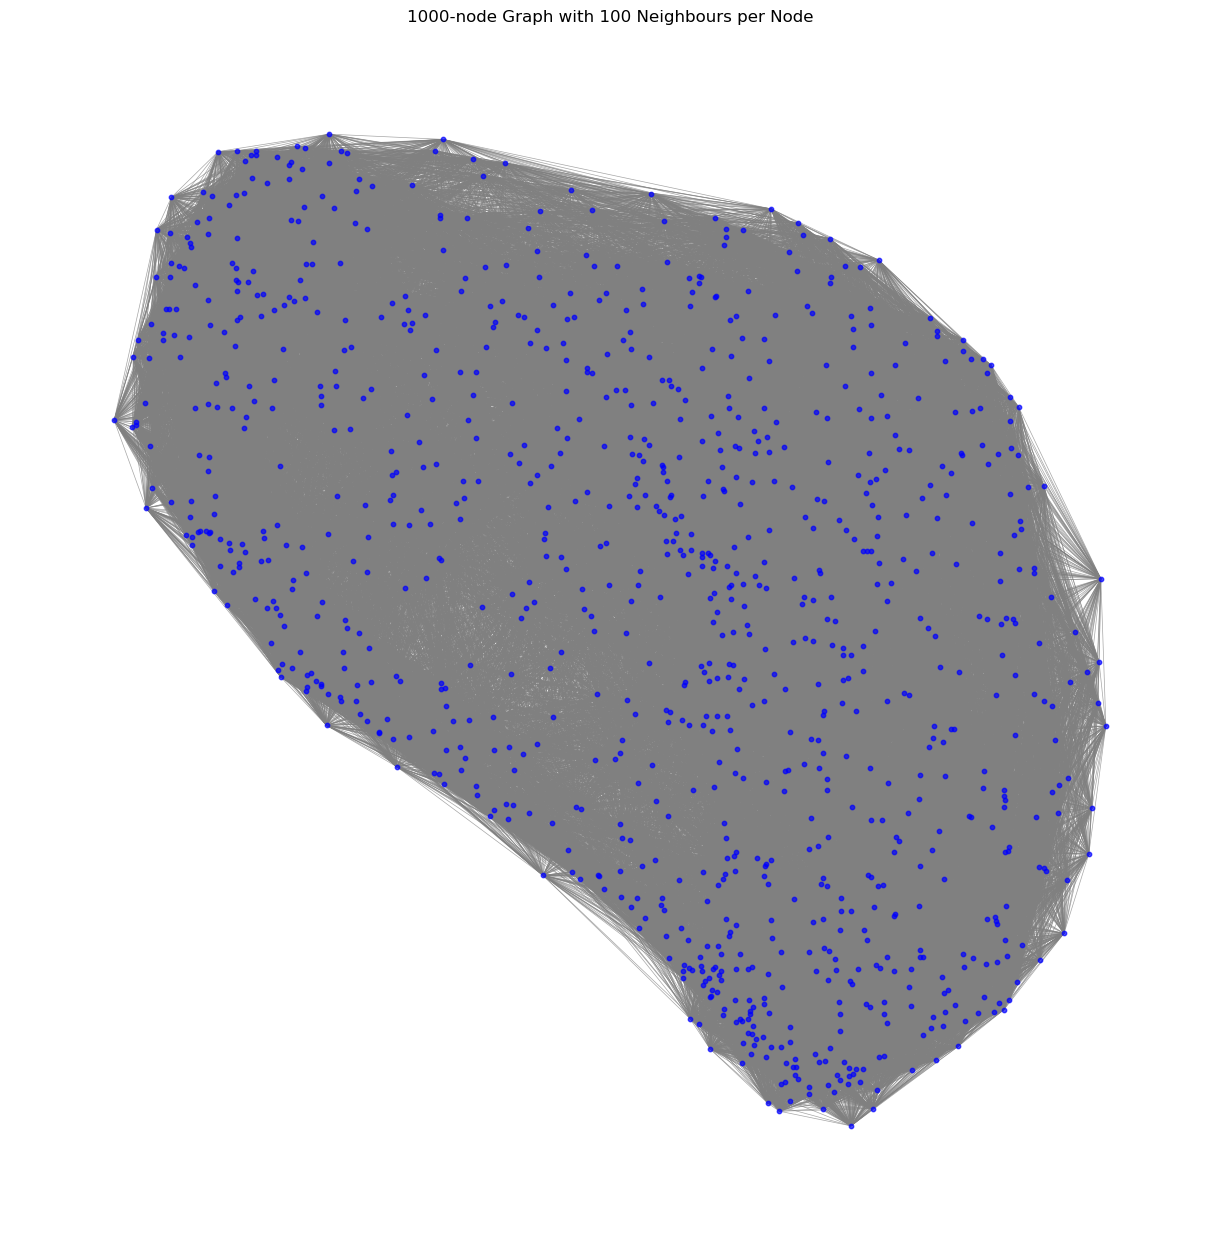

In [75]:
# Plot:
pos = nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=False, node_size=10, node_color='blue', alpha=0.7, edge_color='gray', width=0.5)
plt.title("1000-node Graph with 100 Neighbours per Node")
plt.show()

### Study graph-communities:

In [82]:
k = nx.community.louvain_communities(G)
print('Num communities: ', len(k))

Num communities:  5


In [83]:
cluster_labels = {}


for i, cluster in enumerate(k):

    count_1650 = 0
    count_1675 = 0
    count_1700 = 0
    count_1725 = 0
    count_1750 = 0
    count_1775 = 0
    count_1800 = 0
    count_1825 = 0
    count_1850 = 0
    count_1875 = 0

    num_tunes_cluster = len(cluster)
    all_tune_yrs_cluster = []
    for tune in cluster:
        
        tune_year = int(tune[:4])
        all_tune_yrs_cluster.append(tune_year)

        # Count Classes:
        if num_classes == 5:
            if 1650<= tune_year < 1700:
                count_1650+=1
            if 1700<= tune_year < 1750:
                count_1700+=1 
            if 1750<= tune_year < 1800:
                count_1750+=1 
            if 1800<= tune_year < 1850:
                count_1800+=1 
            if 1850<= tune_year < 1900:
                count_1850+=1 

        if num_classes == 10:
            if 1650<= tune_year < 1675:
                count_1650+=1
            if 1675<= tune_year < 1700:
                count_1675+=1
            if 1700<= tune_year < 1725:
                count_1700+=1 
            if 1725<= tune_year < 1750:
                count_1725+=1 
            if 1750<= tune_year < 1775:
                count_1750+=1 
            if 1775<= tune_year < 1800:
                count_1775+=1 
            if 1800<= tune_year < 1825:
                count_1800+=1 
            if 1825<= tune_year < 1850:
                count_1825+=1 
            if 1850<= tune_year < 1875:
                count_1850+=1 
            if 1875<= tune_year < 1900:
                count_1875+=1 
        
    if num_classes == 5:
        counts = {
            'count_1650': count_1650,
            'count_1700': count_1700,
            'count_1750': count_1750,
            'count_1800': count_1800,
            'count_1850': count_1850
        }

    # Find percentages of each period:
    count_1650_perc =  count_1650 / num_tunes_cluster
    count_1700_perc =  count_1700 / num_tunes_cluster
    count_1750_perc =  count_1750 / num_tunes_cluster
    count_1800_perc =  count_1800 / num_tunes_cluster
    count_1850_perc =  count_1850 / num_tunes_cluster


    if num_classes == 10:
        count_1675_perc =  count_1675 / num_tunes_cluster
        count_1725_perc =  count_1725 / num_tunes_cluster
        count_1775_perc =  count_1775 / num_tunes_cluster
        count_1825_perc =  count_1825 / num_tunes_cluster
        count_1875_perc =  count_1875 / num_tunes_cluster
    
        counts = {
            'count_1650': count_1650,
            'count_1675': count_1675,
            'count_1700': count_1700,
            'count_1725': count_1725,
            'count_1750': count_1750,
            'count_1775': count_1775,
            'count_1800': count_1800,
            'count_1825': count_1825,
            'count_1850': count_1850,
            'count_1875': count_1875,
        }



    # Find cluster mean, standard-dev and normal dist test:
    cluster_mean = np.mean(all_tune_yrs_cluster)
    cluster_std = np.std(all_tune_yrs_cluster)
    normal_dist = stats.normaltest(all_tune_yrs_cluster)

    # Find the variable name and value of the peak count
    peak_var = max(counts, key=counts.get)
    peak = counts[peak_var]
    peak_var = peak_var[6:]
    cluster_labels[i] = peak_var

    if num_classes == 5:
        print(f'Cluster {i}, counts: '
        f'{count_1650} ({count_1650_perc:.2%}), '
        f'{count_1700} ({count_1700_perc:.2%}), '
        f'{count_1750} ({count_1750_perc:.2%}), '
        f'{count_1800} ({count_1800_perc:.2%}), '
        f'{count_1850} ({count_1850_perc:.2%}), '
        f'peak: {peak_var}, '
        f'mean: {round(cluster_mean)}, '
        f'standard-dev: {round(cluster_std, 1)}, '
        f'Normal test: {normal_dist}')
    
    if num_classes == 10:
        print(f'Cluster {i}, counts: '
        f'{count_1650} ({count_1650_perc:.2%}), '
        f'{count_1675} ({count_1675_perc:.2%}), '
        f'{count_1700} ({count_1700_perc:.2%}), '
        f'{count_1725} ({count_1725_perc:.2%}), '
        f'{count_1750} ({count_1750_perc:.2%}), '
        f'{count_1775} ({count_1775_perc:.2%}), '
        f'{count_1800} ({count_1800_perc:.2%}), '
        f'{count_1825} ({count_1825_perc:.2%}), '
        f'{count_1850} ({count_1850_perc:.2%}), '
        f'{count_1875} ({count_1875_perc:.2%}), '
        f'peak: {peak_var}, '
        f'mean: {round(cluster_mean)}, '
        f'standard-dev: {round(cluster_std, 1)}, '
        f'Normal test: {normal_dist}')

Cluster 0, counts: 89 (31.12%), 44 (15.38%), 47 (16.43%), 38 (13.29%), 22 (7.69%), 10 (3.50%), 9 (3.15%), 6 (2.10%), 7 (2.45%), 14 (4.90%), peak: 1650, mean: 1719, standard-dev: 64.3, Normal test: NormaltestResult(statistic=30.692044379063816, pvalue=2.1642490916918765e-07)
Cluster 1, counts: 7 (6.48%), 33 (30.56%), 25 (23.15%), 8 (7.41%), 8 (7.41%), 1 (0.93%), 5 (4.63%), 8 (7.41%), 4 (3.70%), 9 (8.33%), peak: 1675, mean: 1744, standard-dev: 65.9, Normal test: NormaltestResult(statistic=12.732199656359887, pvalue=0.0017188499797927937)
Cluster 2, counts: 0 (0.00%), 7 (4.38%), 10 (6.25%), 14 (8.75%), 7 (4.38%), 17 (10.62%), 20 (12.50%), 27 (16.88%), 36 (22.50%), 22 (13.75%), peak: 1850, mean: 1811, standard-dev: 56.5, Normal test: NormaltestResult(statistic=13.525483825962151, pvalue=0.0011560550219974087)
Cluster 3, counts: 1 (0.56%), 5 (2.79%), 7 (3.91%), 12 (6.70%), 22 (12.29%), 21 (11.73%), 23 (12.85%), 25 (13.97%), 28 (15.64%), 35 (19.55%), peak: 1875, mean: 1813, standard-dev: 54.

In [84]:
### Turn clusters into features and labels (for each tune):

# Empty lists to store
features_vector_lst = []
labels_vector_lst = []

for i, cluster in enumerate(k):

    # Cluster label:
    label = i
    
    # Iterate through each tune in the cluster
    for tune in cluster:

        # Get feature vectors from dict:
        pitch_vector = normalised_pitch_vectors[tune]
        rhythm_vector = normalised_rhythm_vectors[tune]
        combined_feature_vector = pitch_vector + rhythm_vector

        features_vector_lst.append(combined_feature_vector)
        labels_vector_lst.append(label)

# Convert to np arrays:
features_vector = np.asarray(features_vector_lst)     
labels_vector = np.asarray(labels_vector_lst)

# Calculate Davis-Bouldin Score:
db_score = davies_bouldin_score(features_vector, labels_vector)
print('Davis-Bouldin Score: ', db_score)

Davis-Bouldin Score:  1.3440843196906176


/var/folders/sl/ymrr09g50yv065qjdfh1d8h80000gn/T/ipykernel_7010/1047269269.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(community_pos[hull_points, 0], community_pos[hull_points, 1], 'k-', linewidth=2, color=community_colours[i])


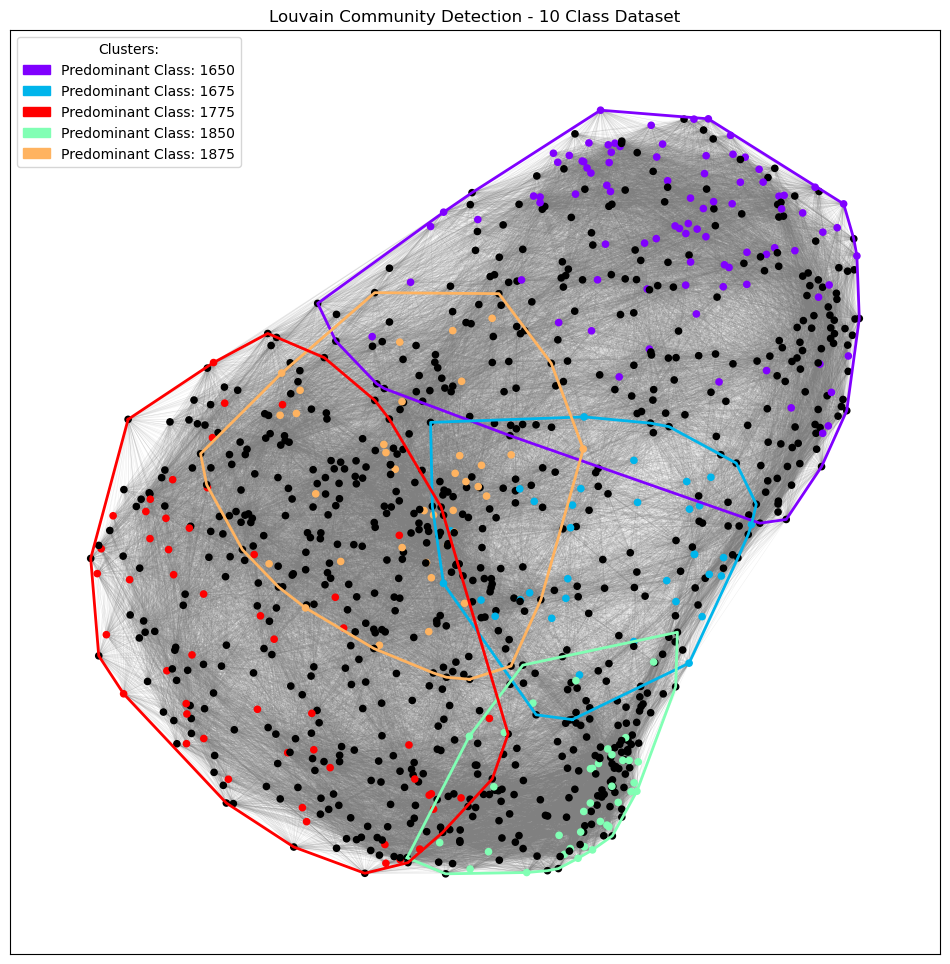

In [86]:


# Create a dictionary assigning a community number and colours to each node:
node_community = {}
for i, community in enumerate(k):
    for node in community:
        node_community[node] = i

community_colours = plt.cm.rainbow(np.linspace(0, 1, len(k)))
colours = []

# Iterate over each node to determine its colour
for node in G.nodes():
    community_id = node_community[node]

    true_year = int(tune_year_labels.loc[tune_year_labels['tune'] == node, 'year'].values[0])
    cluster_year = int(cluster_labels[community_id])

    if true_year == cluster_year:
        colours.append(community_colours[community_id])
    else:
        # Otherwise, black:
        colours.append('black')

handles = [mpatches.Patch(color=community_colours[i], label=f'Predominant Class: {cluster_labels[i]}') for i in range(len(k))]

# Plot the graph:
pos = nx.fruchterman_reingold_layout(G) 
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=colours, cmap=plt.cm.rainbow, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.3, edge_color='Gray')

# Add community boundaries using Convex Hulls:
for i, community in enumerate(k):
    community_pos = np.array([pos[node] for node in community])
    
    # Only proceed if there are enough points to form a convex hull:
    if len(community_pos) >= 3:
        hull = ConvexHull(community_pos)
        hull_points = np.append(hull.vertices, hull.vertices[0]) 
        plt.plot(community_pos[hull_points, 0], community_pos[hull_points, 1], 'k-', linewidth=2, color=community_colours[i])

# Sort the handles by the cluster label:
sorted_handles = sorted(handles, key=lambda handle: int(handle.get_label().split(': ')[1]))


plt.legend(handles=sorted_handles, loc='best', title='Clusters:')
plt.title("Louvain Community Detection - 10 Class Dataset")
plt.show()
